## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk.stem import SnowballStemmer

from scipy import stats

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Dataset Preprocessing

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
1263,2218,THOR,"Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?",Thor,2011,15,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3951,7527,THOR,They'll try to leave the city.,Avengers: Age of Ultron,2015,6,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4198,8890,TONY STARK,"Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",Captain America: Civil War,2016,15,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6078,14843,BRUCE BANNER,It was worse for me. Because I lost twice. First Hulk lost. Then Banner lost. Then we all lost.,Avengers: Endgame,2019,23,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,141,TONY STARK,"Okay, here’s what I need... S-Category missiles. Lot 7043. The S-30 explosive tritonal. And a dozen of the S-76. Mortars: M-Category #1, 4, 8, 20, and 60. M- 229’s, I need eleven of these. Mines: the pre-90s AP 5s and AP 16s.",Iron Man,2008,49,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1788
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,442
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(['Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?',
        "They'll try to leave the city.",
        "Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",
        'It was worse for me.  Because I lost twice.  First Hulk lost.  Then Banner lost.  Then we all lost.',
        'Okay, here’s what I need... S-Category missiles.  Lot 7043.  The S-30 explosive tritonal.  And a dozen of the S-76.  Mortars: M-Category #1, 4, 8, 20, and 60.  M- 229’s, I need eleven of these.  Mines: the pre-90s AP 5s and AP 16s. ',
        'A little.',
        "You really think I'd need one? My wife kicked me out.",
        'Is this is a test?', 'What about Ultron himself?',
        'Who put me there? Who put me there?!'], dtype='<U1388'),
 array(['THOR', 'THOR', 'TONY STARK', 'BRUCE BANNER', 'TONY STARK',
        'STEVE ROGERS', 'NICK FURY', 'STEVE ROGERS', 'STEVE ROGERS',
        'LOKI'], dtype='<U16'))

## Character Similarity

The similarity score used here is the dot product between the unit word count vectors of every word a character has ever said.  To get this score, we just count how many times a character has said every word, divide the vector by it's norm, and then do a dot product with another character's vector.

In [5]:
vect = CountVectorizer()
vect.fit(X)
len(vect.vocabulary_)

5947

In [6]:
main_characters = mcu_subset['character'].value_counts().index.to_numpy()

word_count_vectors = np.empty(shape=(0, len(vect.vocabulary_)))

for i in range(len(main_characters)):
    new_vector = np.sum(vect.transform(mcu_subset[mcu_subset['character'] == main_characters[i]]['line'].to_numpy()).toarray(), axis=0)
    word_count_vectors = np.concatenate((word_count_vectors, np.expand_dims(new_vector, axis=0)), axis=0)    
    
pd.DataFrame(word_count_vectors, index=main_characters, columns=vect.get_feature_names())

,00,000,011,04,07,10,100,11,117,119,...,zap,zaps,zemo,zero,zip,zola,zone,zoning,zoo,zucchini
TONY STARK,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,...,1.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0
STEVE ROGERS,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
THOR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETER PARKER,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NATASHA ROMANOFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
PEPPER POTTS,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
BRUCE BANNER,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
NICK FURY,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
LOKI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JAMES RHODES,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


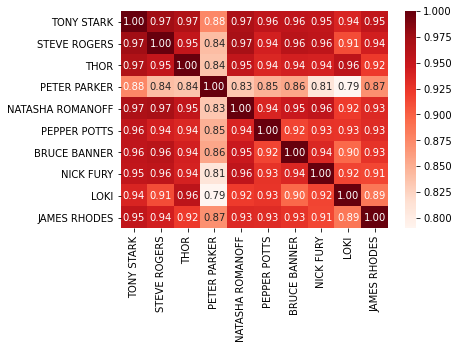

In [7]:
character_similarity = np.zeros(shape=(len(main_characters), len(main_characters)))

for i in range(0, len(word_count_vectors)):
    for j in range(i, len(word_count_vectors)):
        v_hat = word_count_vectors[i,:] / np.linalg.norm(word_count_vectors[i,:])
        u_hat = word_count_vectors[j,:] / np.linalg.norm(word_count_vectors[j,:])
        
        similarity_score = np.dot(v_hat, u_hat)
        
        character_similarity[i][j] = similarity_score
        character_similarity[j][i] = similarity_score

character_similarity = pd.DataFrame(character_similarity, columns=main_characters, index=main_characters)

dump(character_similarity, "./front_end/character_similarity.joblib")

sns.heatmap(character_similarity, annot=True, fmt='.2f', cmap=plt.cm.Reds)

The characters are most likely so similar to each other because they are all speaking English, which like any language, is very structured and systematic.  According to [Michael Steven's application](https://www.youtube.com/watch?v=fCn8zs912OE) of Zipf's Law and the Pareto Distribution, the top 20% of words (words like "the" "I" "he" "she") make up 80% of all speech.  

Why is Peter Parker so unique compared to the other characters?  Let's take a look.

In [8]:
vocabulary_table = pd.DataFrame({'vector_sum': np.sum(word_count_vectors, axis=1), 
                                 'vector_mean': np.mean(word_count_vectors, axis=1), 
                                 'vector_std': np.std(word_count_vectors, axis=1),
                                 'vocabulary_size': np.count_nonzero(word_count_vectors, axis=1)})

words_unique_to_character_indicies = []
for i in range(0,word_count_vectors.shape[0]):
    all_other_word_count_vectors = np.delete(word_count_vectors, i, axis=0)
    
    for j in range(0, all_other_word_count_vectors.shape[0]):

        columns_with_zero = np.argwhere(all_other_word_count_vectors[j] == 0).flatten()

        if j == 0:
            common_columns_with_zero = columns_with_zero
        else:
            common_columns_with_zero = np.intersect1d(common_columns_with_zero, columns_with_zero)
        
    words_unique_to_character_indicies.append(common_columns_with_zero)
    
words_unique_to_character = []

for i in range(0, len(words_unique_to_character_indicies)):
    words_unique_to_character.append(len(words_unique_to_character_indicies[i]))

vocabulary_table['words_unique_to_character'] = words_unique_to_character
vocabulary_table['percent_unique_to_character'] = vocabulary_table['words_unique_to_character'] / vocabulary_table['vocabulary_size']

vocabulary_table.index = main_characters

vocabulary_table.sort_values(by='percent_unique_to_character', inplace=True, ascending=False)

vocabulary_table

,vector_sum,vector_mean,vector_std,vocabulary_size,words_unique_to_character,percent_unique_to_character
TONY STARK,20777.0,3.493694,23.465857,3439,1550,0.450712
THOR,8663.0,1.456701,10.390926,1500,387,0.258000
LOKI,3793.0,0.637801,4.828239,962,233,0.242204
NICK FURY,4298.0,0.722717,4.830223,1223,280,0.228945
STEVE ROGERS,8026.0,1.349588,9.356118,1484,304,0.204852
JAMES RHODES,3238.0,0.544476,3.747876,921,172,0.186754
NATASHA ROMANOFF,4338.0,0.729443,5.092447,1127,207,0.183673
PETER PARKER,5034.0,0.846477,5.749856,917,161,0.175573
PEPPER POTTS,3223.0,0.541954,4.254757,842,135,0.160333
BRUCE BANNER,3477.0,0.584665,3.955914,930,136,0.146237


### Words Unique to Peter Parker

In [9]:
np.array(vect.get_feature_names())[list(words_unique_to_character_indicies[3])]

array(['45', 'aaaaarg', 'aahhhh', 'academic', 'ahem', 'algebra',
       'anyways', 'awe', 'aww', 'backpack', 'bank', 'barium', 'beamed',
       'berlin', 'bicycle', 'bike', 'bodega', 'books', 'borough', 'bread',
       'btw', 'builds', 'bus', 'buyers', 'calculus', 'cancels', 'cars',
       'col', 'combining', 'computers', 'coolest', 'curious',
       'deactivate', 'decathlon', 'delmar', 'dialed', 'disappointed',
       'dissolve', 'dominican', 'driven', 'dronie', 'dvd', 'especially',
       'evidence', 'expelled', 'explode', 'fake', 'fetch', 'flat',
       'flexibility', 'flipped', 'footloose', 'freaks', 'girlfriend',
       'glowy', 'gotcha', 'grand', 'gravity', 'grenade', 'handsome',
       'headlights', 'hijacked', 'hips', 'hogan', 'holy', 'homecoming',
       'hurry', 'im', 'impress', 'input', 'instant', 'intern',
       'intimidating', 'intuitive', 'invisible', 'itchy', 'jerks',
       'joking', 'karen', 'lair', 'lamp', 'larbs', 'leaves', 'legs',
       'license', 'listened', 'liz

Peter Parker only has 4 movie appearances, which is less than all the other characters (9, 10, 7, 10, 7, 7, 7, 6, 8).  However, this doesn't seem to have an effect on his word count vector.  Above, you can see that the sum, mean, and standard deviation of his word count vector do not seem to be out of the ordinary compared to the other characters.

Another hypothesis on why Peter Parker is so unique is his age.  He is much younger than all the other characters used, and therefore might talk about different topics, like high school (homecoming, field trips, homework, ...).

Finally, Peter Parker might be so unique because he's not part of the larger Avengers team.  The "friendly neighborhood Spider-Man" deals with much smaller problems than the other Avengers.  For example, the Avengers team might be more likely to deal with governments, aliens, SHIELD, and large scale enemies than Peter.  One counter argument to this hypothesis is Pepper Potts, who is also not part of the Avengers team and also has high similarity with the other characters.  However, her close interaction with Tony Stark might make her discuss these same issues when she speaks.  More evidence for this can be seen in the confusion matrix / recalls.  Peter Parker performs the highest out of any of the characters, which suggests that his dialogue style is the most identifiable / unique.

The probable answer is that Peter Parker is so unique for all of the reasons mentioned above together. Peter Parker is arguably the most unique character in the MCU, which is why he is such a fan favorite.  If a trascript for Spider-Man: Far Frome Home was completed and added to the dataset, it would be interesting to see how that affects this similarity.   

## Character Development

In [10]:
prod_model = load("./front_end/production_model.joblib")

prod_model

Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

### Import Movie Table

Used to get the years of movies to sort by.

In [11]:
movies = pd.read_csv("./data/movies.csv")
movies.set_index('movie', inplace=True)
movies

,is transcript,lines,runtime min,url,words,year,characters
movie,,,,,,,
Iron Man,False,834,126,https://www.scriptslug.com/assets/uploads/scripts/iron-man-2008.pdf,10004,2008,37
Iron Man 2,True,1010,124,https://transcripts.fandom.com/wiki/Iron_Man_2,11342,2010,42
Thor,False,1007,114,https://www.scriptslug.com/assets/uploads/scripts/thor-2011.pdf,9299,2011,39
Captain America: The First Avenger,True,688,124,https://transcripts.fandom.com/wiki/Captain_America:_The_First_Avenger,7482,2011,70
The Avengers,False,1027,143,https://www.scriptslug.com/assets/uploads/scripts/the-avengers-2012.pdf,10643,2012,54
Iron Man 3,True,1043,131,https://transcripts.fandom.com/wiki/Iron_Man_3,10875,2013,57
Thor: The Dark World,True,734,112,https://transcripts.fandom.com/wiki/Thor:_The_Dark_World,7418,2013,41
Captain America: The Winter Soldier,True,841,136,https://transcripts.fandom.com/wiki/Captain_America:_The_Winter_Soldier,8696,2014,65
Ant-Man,True,867,117,https://transcripts.fandom.com/wiki/Ant-Man,9335,2015,33


###  Development Helper Class

In [18]:
class Development_Helper():
    """
    Used to keep data / perform calculations in an organized fashion.
    """
    def __init__(self, character, model, cv_folds, score_method='balanced accuracy', verbose=0):
        
        pd.options.mode.chained_assignment = None  # default='warn'
        
        self.character = character   
        self.model = model
        self.score_method = score_method
        self.verbose = verbose
        
        self.set = mcu_subset[mcu_subset['character'] == self.character]
        self.X = self.set["line"].to_numpy().astype(str)
        self.y = self.set["movie"].to_numpy().astype(str)
        
        self.vect = CountVectorizer()
        self.vect.fit(self.X)
        
        self.movie_list = movies[movies.index.isin(self.set['movie'].unique())]['year'].index
        self.first_half_movies = self.movie_list[0:math.ceil(len(self.movie_list) / 2)]
        self.second_half_movies = self.movie_list[math.ceil(len(self.movie_list) / 2):]
        
        self.set['movie half'] = self.set['movie'].isin(self.second_half_movies)
        self.set['movie half'].replace({False: 'FIRST HALF', True: 'SECOND HALF'}, inplace=True)
        self.binary_y = self.set["movie half"].to_numpy().astype(str)
    
        self.cv_folds = cv_folds
        self.cross_validator = KFold(n_splits=cv_folds, random_state=RANDOM_SEED, shuffle=True)
        
        self.halves_balanced_accuracy = None
        self.halves_similarity = None
        self.movie_similarity_table = None
        self.confusion_matrix = None
        
        
    def get_all_movies_balanced_accuracy(self):
        if self.confusion_matrix is None:
            self._make_confusion_matrix_()
            
        return np.mean(np.diagonal(self.confusion_matrix))
        
    def get_halves_balanced_accuracy(self):
        if self.halves_balanced_accuracy is None:
            yhat = cross_val_predict(self.model, self.X, self.binary_y, cv=self.cross_validator, n_jobs=-1, verbose=self.verbose)
            self.halves_balanced_accuracy =  metrics.balanced_accuracy_score(self.binary_y,yhat)

        return self.halves_balanced_accuracy


    def get_halves_similarity(self):
        if self.halves_similarity is None:
            word_count_vectors = np.empty(shape=(0, len(self.vect.vocabulary_)))

            pre_vector = np.sum(self.vect.transform(self.X[np.argwhere(self.binary_y == 'FIRST HALF').flatten()]).toarray(), axis=0)
            post_vector = np.sum(self.vect.transform(self.X[np.argwhere(self.binary_y == 'SECOND HALF').flatten()]).toarray(), axis=0)

            word_count_vectors = np.concatenate((word_count_vectors, np.expand_dims(pre_vector, axis=0)), axis=0)    
            word_count_vectors = np.concatenate((word_count_vectors, np.expand_dims(post_vector, axis=0)), axis=0)    

            v_hat = word_count_vectors[0,:] / np.linalg.norm(word_count_vectors[0,:])
            u_hat = word_count_vectors[1,:] / np.linalg.norm(word_count_vectors[1,:])

            self.halves_similarity = np.dot(v_hat, u_hat)
            

        return self.halves_similarity
    
    def plot_movie_similarity(self):
        if self.movie_similarity_table is None:
            word_count_vectors = np.empty(shape=(0, len(self.vect.vocabulary_)))

            for i in range(len(self.movie_list)):
                new_vector = np.sum(self.vect.transform(self.X[np.argwhere(self.y == self.movie_list[i]).flatten()]).toarray(), axis=0)
                word_count_vectors = np.concatenate((word_count_vectors, np.expand_dims(new_vector, axis=0)), axis=0)    

            character_movie_similarity = np.zeros(shape=(len(self.movie_list), len(self.movie_list)))

            for i in range(0, len(self.movie_list)):
                for j in range(i, len(self.movie_list)):
                    v_hat = word_count_vectors[i,:] / np.linalg.norm(word_count_vectors[i,:])
                    u_hat = word_count_vectors[j,:] / np.linalg.norm(word_count_vectors[j,:])

                    similarity_score = np.dot(v_hat, u_hat)

                    character_movie_similarity[i][j] = similarity_score
                    character_movie_similarity[j][i] = similarity_score

            self.movie_similarity_table = pd.DataFrame(character_movie_similarity, columns=self.movie_list, index=self.movie_list)

        sns.heatmap(self.movie_similarity_table, annot=True, fmt='.2f', cmap=plt.cm.Reds)
        plt.title(self.character.title() + "'s Self Similarity Accross Movies")
        
    def plot_confusion_matrix(self):
        if self.confusion_matrix is None:
            self._make_confusion_matrix_()
            
        plt.title(self.character.title() + "'s Confusion Matrix Accross Movies")
        sns.heatmap(self.confusion_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)
        
    def _make_confusion_matrix_(self):
        if self.verbose > 0:
            print('Using', self.folds, 'folds to make do CV predictions')

        yhat = cross_val_predict(self.model, self.X, self.y, cv=self.cross_validator, n_jobs=-1, verbose=self.verbose)

        conf_matrix = pd.DataFrame(metrics.confusion_matrix(self.y, yhat, labels=self.movie_list))
        normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
        normalized_conf_matrix.columns = pd.Series(self.movie_list, name="Predicted Movie")
        normalized_conf_matrix.index = pd.Series(self.movie_list, name="True Movie")

        self.confusion_matrix = normalized_conf_matrix
        return self.confusion_matrix           

In [19]:
folds = 100
verbose = 0

tony_dev_helper = Development_Helper('TONY STARK', prod_model, cv_folds=folds, verbose=verbose)
steve_dev_helper = Development_Helper('STEVE ROGERS', prod_model, cv_folds=folds, verbose=verbose)
thor_dev_helper = Development_Helper('THOR', prod_model, cv_folds=folds, verbose=verbose)
peter_dev_helper = Development_Helper('PETER PARKER', prod_model, cv_folds=folds, verbose=verbose)
natasha_dev_helper = Development_Helper('NATASHA ROMANOFF', prod_model, cv_folds=folds, verbose=verbose)
pepper_dev_helper = Development_Helper('PEPPER POTTS', prod_model, cv_folds=folds, verbose=verbose)
bruce_dev_helper = Development_Helper('BRUCE BANNER', prod_model, cv_folds=folds, verbose=verbose)
fury_dev_helper = Development_Helper('NICK FURY', prod_model, cv_folds=folds, verbose=verbose)
loki_dev_helper = Development_Helper('LOKI', prod_model, cv_folds=folds, verbose=verbose)
james_dev_helper = Development_Helper('JAMES RHODES', prod_model, cv_folds=folds, verbose=verbose)

dev_helpers = [tony_dev_helper, steve_dev_helper, thor_dev_helper, peter_dev_helper, natasha_dev_helper,
              pepper_dev_helper, bruce_dev_helper, fury_dev_helper, loki_dev_helper, james_dev_helper]

In [17]:
main_characters = mcu_subset['character'].value_counts().index.to_numpy()
development_metrics = pd.DataFrame(columns=['all movies balanced accuracy', 'halves balanced accuracy', 'halves similarity'], index=main_characters)

for dev_helper in dev_helpers:
    development_metrics.loc[dev_helper.character]['all movies balanced accuracy'] = dev_helper.get_all_movies_balanced_accuracy()
    development_metrics.loc[dev_helper.character]['halves balanced accuracy'] = dev_helper.get_halves_balanced_accuracy()
    development_metrics.loc[dev_helper.character]['halves similarity'] = dev_helper.get_halves_similarity()
    
development_metrics.sort_values(by='halves balanced accuracy', inplace=True, ascending=False)

development_metrics

,all movies balanced accuracy,halves balanced accuracy,halves similarity
THOR,0.36522,0.723404,0.944218
BRUCE BANNER,0.302803,0.67203,0.875855
JAMES RHODES,0.271285,0.666667,0.875973
PEPPER POTTS,0.302164,0.65812,0.814705
NICK FURY,0.267709,0.644174,0.902947
LOKI,0.338164,0.641986,0.912329
TONY STARK,0.244635,0.605388,0.974445
STEVE ROGERS,0.218069,0.576405,0.93901
NATASHA ROMANOFF,0.195742,0.573686,0.930479
PETER PARKER,0.332903,0.557189,0.793645


The table above shows several metrics used to describe a character's development across movies.  The `all movies balanced accuracy` describes the performance of a model where the input is the character's line and the labels are what movie that line is from.  In other words, it describes how identifiable the character across movies.  The `havles balanced accuracy` describes the same thing, only the movies are divided up into halves ('FIRST HALF' and 'SECOND HALF') by year released.  The `halves similarity` score describes the similarity score defined in the Character Similarity section between the character's 'FIRST HALF' movies and their 'SECOND HALF' movies.

### Thor analysis

When creating this section, I wanted to explore Thor's character development specifically.  Thor in *Thor,
Thor: The Dark World, The Avengers*, and *Avengers: Age of Ultron*, is very different from
Thor in *Thor: Ragnarok, Avengers: Infinity War*, and *Avengers: Endgame*.  *Thor: Ragnorak* is
a turning point for Thor, as he takes on a more comedic role than previously.  Chris Hemsworth, the producers, and the screen writers wanted to take the character in a different direction in this movie, and it definitely shows in the following movies as well.  In other words, his character in the first half of all his movies are more serious than his character in the second half of all his movies.

As shown in the table above, Thor has a `halves balanced accuracy` of 0.723404, meaning we can determine with 72.3404% accuracy whether one of Thor's lines is pre or post *Thor: Ragnarok*.  I would say this is indicative of the changes that Chris Hemsworth and the producers imposed upon Thor.

In [25]:
pd.DataFrame(thor_dev_helper.first_half_movies)

,movie
0,Thor
1,The Avengers
2,Thor: The Dark World
3,Avengers: Age of Ultron


In [26]:
pd.DataFrame(thor_dev_helper.second_half_movies)

,movie
0,Thor: Ragnarok
1,Avengers: Infinity War
2,Avengers: Endgame


All Movies Balanced Accuracy: 0.36521959634073287


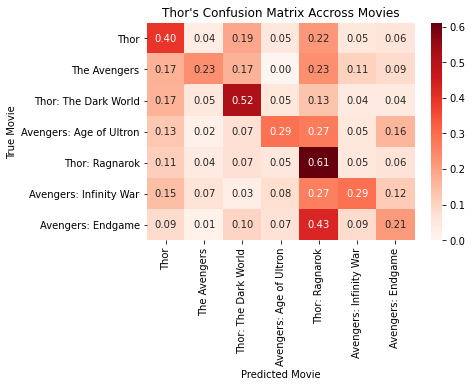

In [27]:
thor_dev_helper.plot_confusion_matrix()
print("All Movies Balanced Accuracy:",thor_dev_helper.get_all_movies_balanced_accuracy())

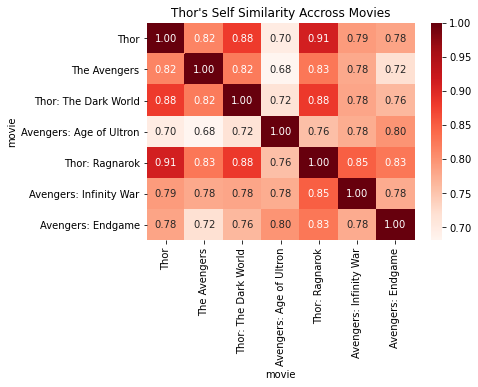

In [21]:
thor_dev_helper.plot_movie_similarity()